We solve the steady advection dominated skew to mesh benchmark problem using the various methods encountered in class. The problem entails solving the advection diffusion equation 
$$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa = 10^{-6},\text{ and } \mathbf{a} = \left(\cos\left(\frac{\pi}{4}\right), \sin\left(\frac{\pi}{4}\right)\right)$$

with dirichlet boundary conditions as shown below 


<img src="files/advectiondominatedskewmesh.jpg">

(picture taken from this [paper](https://doi.org/10.1016/j.cma.2004.10.008))

A good numerical solution will have minimal oscillation and boundary layers at the top and right boundaries. 

#### Methods Used
1. Galerkin (strong BCs)
2. SUPG (strong BCs)
3. Galerkin/Least squares (strong BCs)
4. Galerkin/ Nitsche
5. SUPG/Nitsche

In [1]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## 1. Galerkin (strong BCs)

We multiply by a test function $w$ and integrate by parts to get:
$$ B(w, u) = \int_\Omega (\kappa \, w_{, j}\, u_{, j} \,-\, u\, w_{, k} \,a_k) \, dx = L(w) = 0$$

but the test space is finite dimensional so $w = \sum_{B=1}^{A_{\text{max}}-1} c_B N_B$ where $N_B$ is a basis of the test space. 
Thus $$ \sum_{B=1}^{A_{\text{max}}-1} c_B \left(\int_\Omega (\kappa \, N_{B, j}\, u_{, j} \,-\, u\, N_{B, k} \,a_k) \, dx\right) = 0 $$

Since the coefficients $c_B$ are arbitrary, we take $c_B = \delta_{AB}$ and this gives us the version of the weak form we will solve in Nutils

**Weak Form**: $$ \mathbf{\int_\Omega (\kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k} \,a_k) \, dx = 0}$$



optimize > solve > solving 120 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 120/961 dofs
optimize > optimum value 9.62e-03
solve > solving 841 dof system to machine precision using direct solver
solve > solver returned with residual 8e-15


<IPython.core.display.Javascript object>


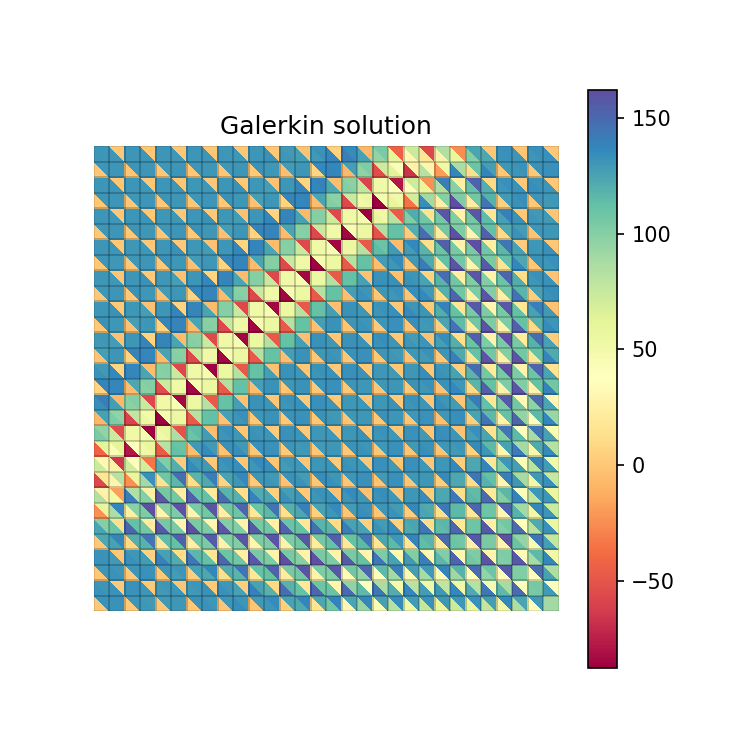

<IPython.core.display.Javascript object>


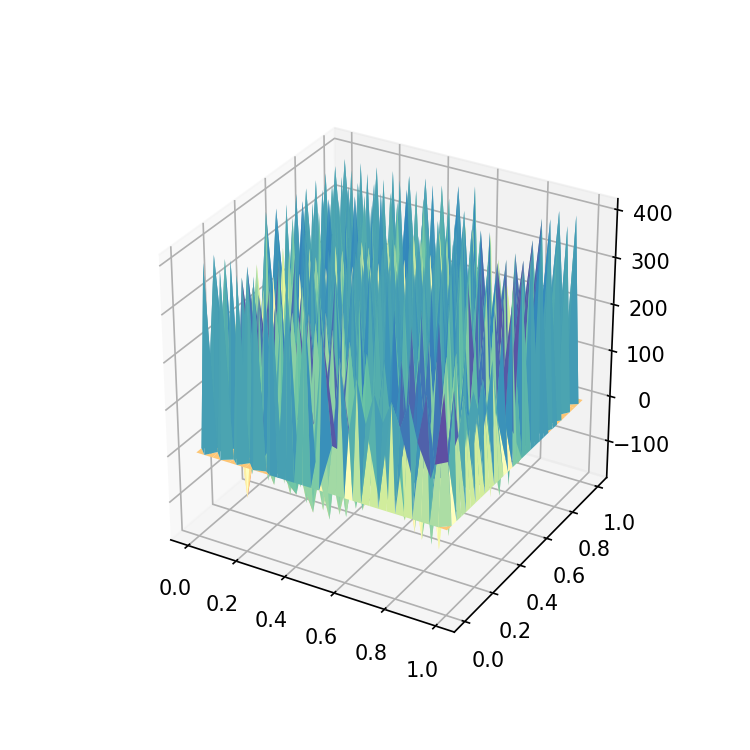

In [33]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square' #square meshes. Other options are 'triangle' and 'mixed'

topo, geom = ntl.mesh.unitsquare(nelems, etype)  #ntl.mesh.rectilinear([np.linspace(0,1, 31), np.linspace(0,1, 31) ])
ns = ntl.function.Namespace()
ns.x = geom
theta = np.pi/4
ns.a = np.array([np.cos(np.pi/4), np.sin(np.pi/4)])
ns.kappa = 1e-6
ns.basis = topo.basis('lagrange', degree = degree) #other options include 'std' (C-0 splines) and 'spline' (default C-(deg -1))
ns.u = 'basis_A ?dofs_A'


#Dirichlet boundary condition
badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2) #This creates a partition of unity on each axes at x_i = 0.2

ns.badbnd = badbnd[1] #topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)]) <--ONLY WORKS FOR SQUARE MESH

sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_A,j u_,j  - u basis_A,k a_k) d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## 2. SUPG (strong BCs)

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 108 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 8e-17
optimize > constrained 108/784 dofs
optimize > optimum value 5.18e-03
solve > solving 676 dof system to machine precision using direct solver
solve > solver returned with residual 2e-16


<IPython.core.display.Javascript object>


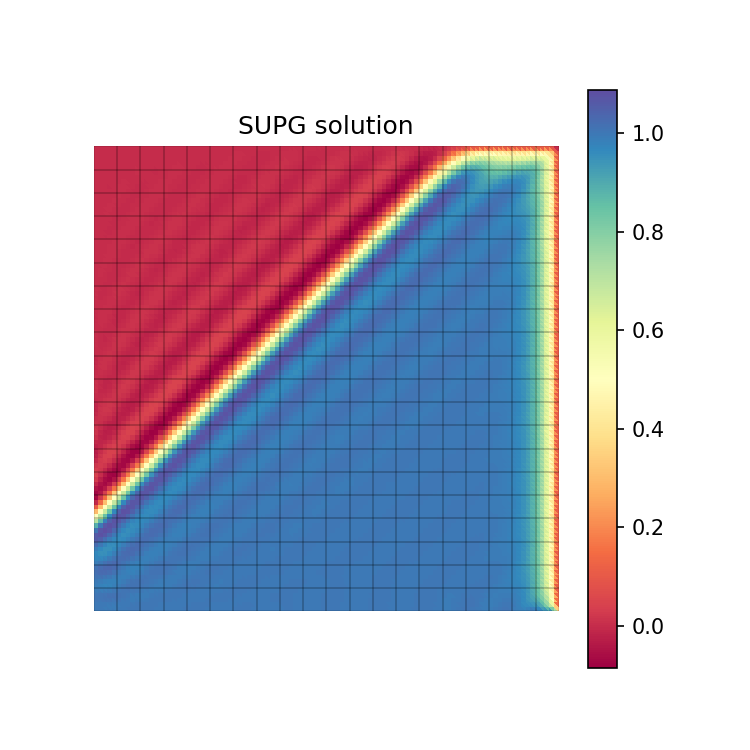

<IPython.core.display.Javascript object>


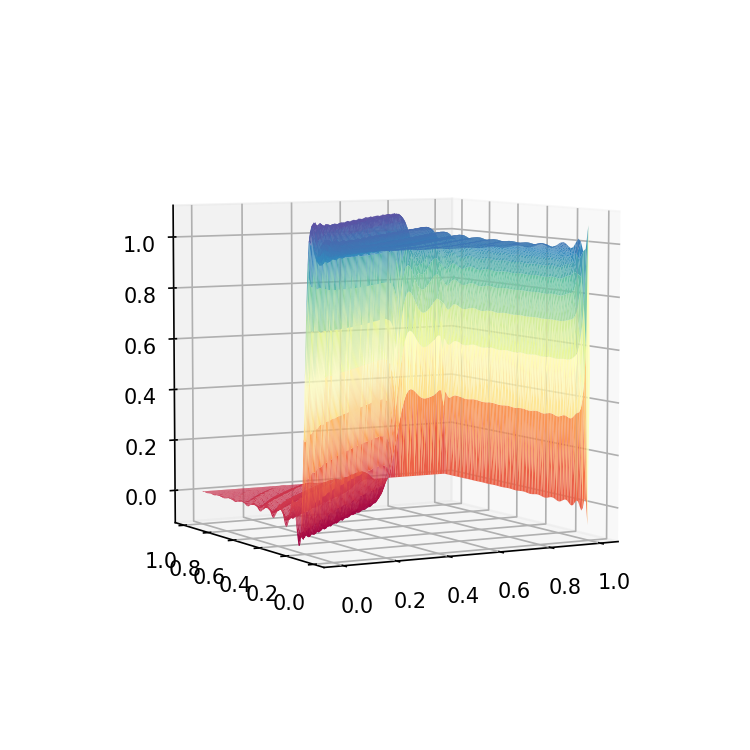

In [21]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 8 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)])
ns.kappa = 1e-6
ns.basis = topo.basis('spline', degree = degree)
ns.u = 'basis_i ?dofs_i'


#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2)
ns.badbnd = badbnd[1]   #topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)]) ONLY WORKS FOR SQUARE MESH

#sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)#ischeme = 'bezier6')#
#sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns,degree = degree*2 )  #ischeme = 'bezier6')#
#sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2) #ischeme = 'bezier6')# 
#sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2) #ischeme = 'bezier6' )#
#cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15)#this applies the boundary condition to u


#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 6)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)
#ax2.set_zlim(-1, 3)
#'''

## 3. Galerkin/Least squares (strong BCs)
**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, (-\kappa\,N_{A, rr}\,+\, a_n N_{A, n}) 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 400 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 3e-17
optimize > constrained 400/10201 dofs
optimize > optimum value 1.41e-03
solve > solving 9801 dof system to machine precision using direct solver
solve > solver returned with residual 2e-16


<IPython.core.display.Javascript object>


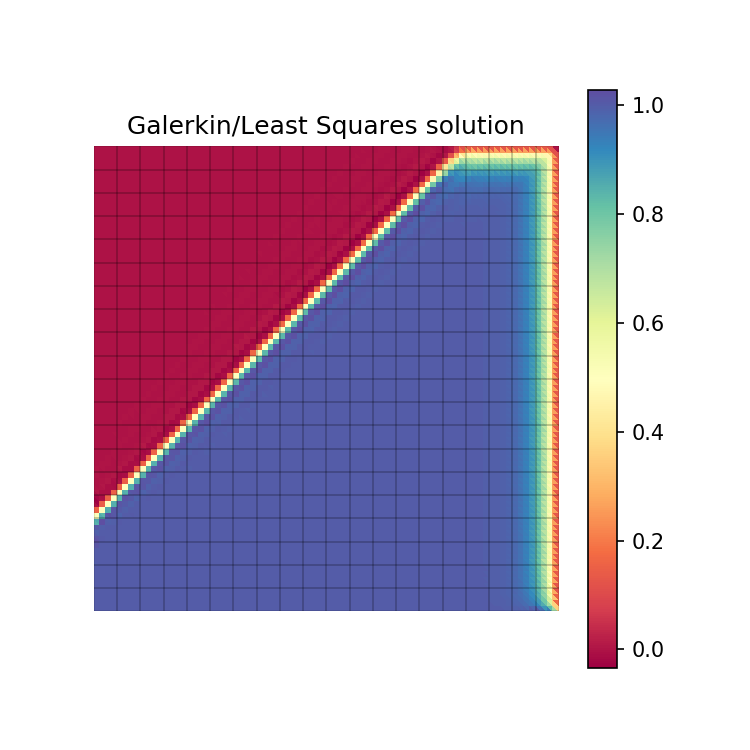

<IPython.core.display.Javascript object>


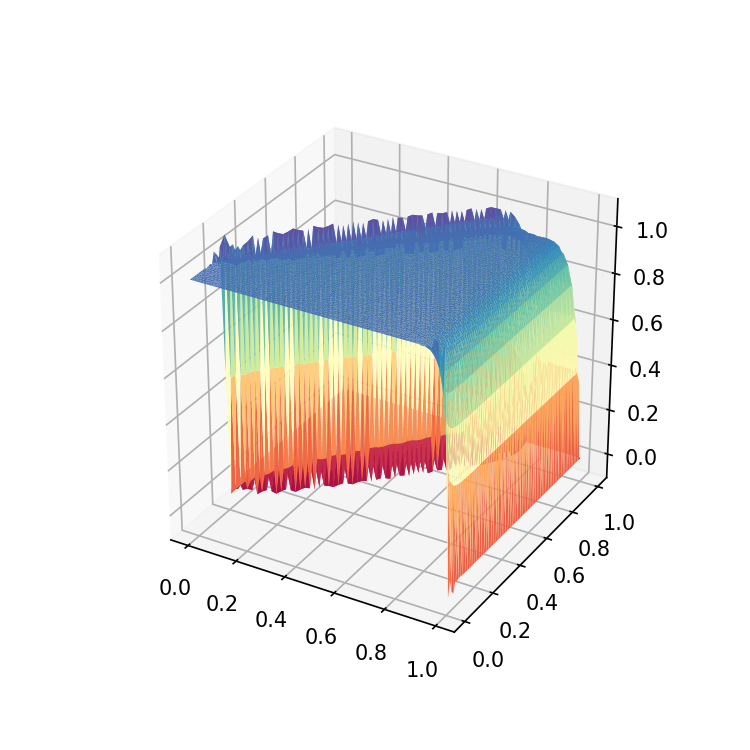

In [53]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 5 #degree of basis functions. degree = 1 gives SUPG
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)])
ns.kappa = 1e-6
ns.basis = topo.basis('bernstein', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2)
ns.badbnd = badbnd[1] #topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])
sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral('tau (-kappa basis_i,mm + a_k basis_i,k) (-kappa u_,jj + a_n u_,n)  d:x' @ ns,
                     degree= degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 5)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Least Squares solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## 4. Galerkin/ Nitsche Method

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,+\,a_k\,u_{,k}  N_{A} \, dx\, -\,\int_\Gamma \kappa N_A u_{,i}n_i\,d\Gamma \,+ \int_\Gamma \frac{\kappa\lambda}{h}N_A (u-g)\,d\Gamma  -s\int_\Gamma \kappa (u - g) N_{A, k} n_k d\Gamma $$

Where $g$ is the dirichlet boundary condition, $\lambda$ is the lagrange multiplier, $n$ is the unit outward normal and $s$ is the switch between the symmetric and skew-symmetric formulations of the method

solve > solving 961 dof system to machine precision using direct solver
solve > solver returned with residual 9e-17


<IPython.core.display.Javascript object>


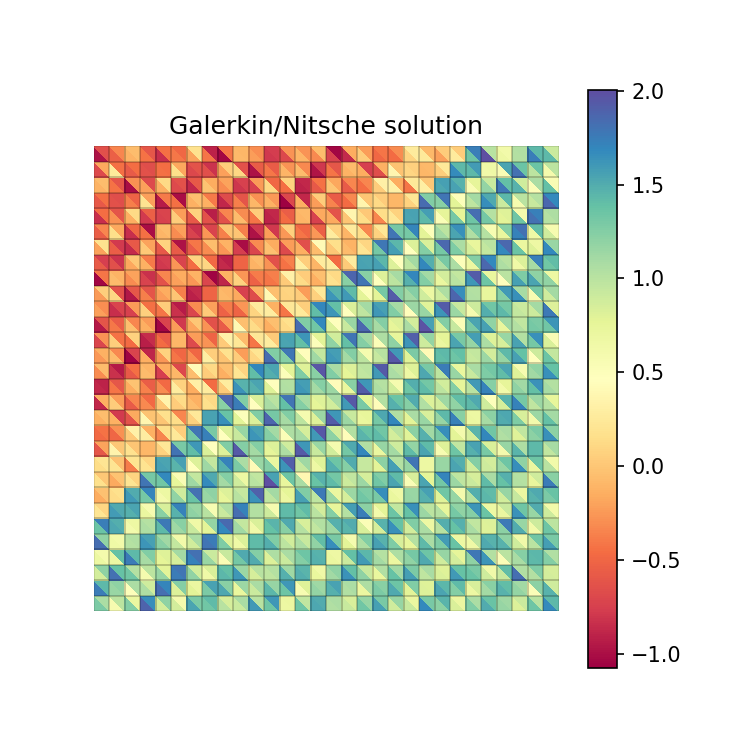

<IPython.core.display.Javascript object>


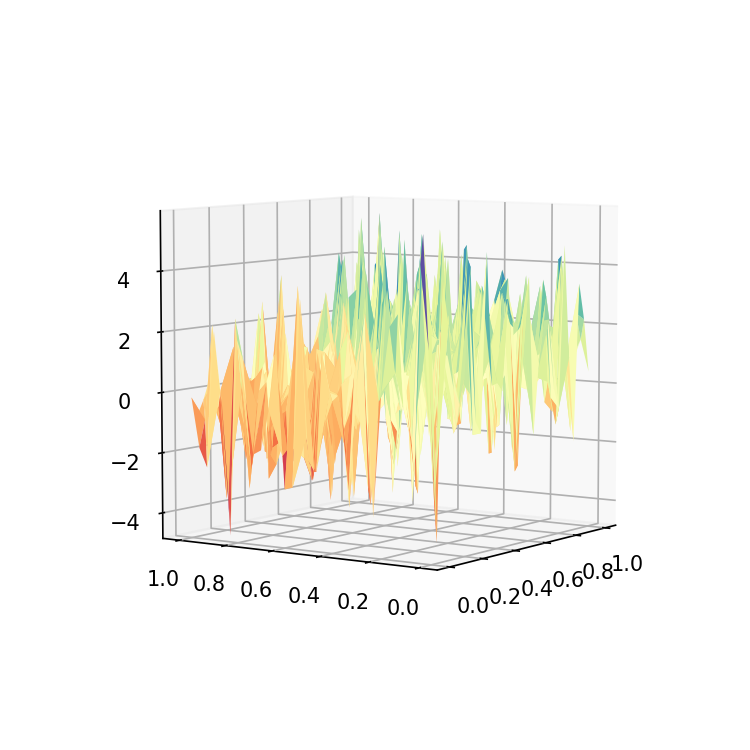

In [35]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions. degree = 1 gives SUPG
nelems = 30 #number of elements along edge of unit square
etype = 'square' #square meshes

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)]) #advection
ns.kappa = 1e-6
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.s = 1 # 1 or -1 depending on whether you want symmetric or skew-symmetric 
ns.lamb = 17 # lagrange multiplier
badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2)
ns.badbnd = badbnd[1]

#residual
res = topo.integral( '(kappa basis_i,j u_,j  + u_,n  a_n basis_i) d:x' @ ns, degree = degree * 2) 
res -= topo.boundary.integral('kappa basis_i u_,k n_k d:x' @ns, degree = degree * 2)
    #weak BCs
res += topo.boundary['top'].integral('kappa lamb basis_i u / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['right'].integral('kappa lamb basis_i u / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['bottom'].integral('kappa lamb basis_i (u - 1) / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['left'].integral('kappa lamb basis_i (u - badbnd) / (h)  d:x' @ ns, degree= degree * 2)

res -= topo.boundary['top'].integral('s kappa basis_i,j u n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['right'].integral('s kappa  basis_i,j u n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['bottom'].integral('s kappa basis_i,j (u - 1) n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['left'].integral('s kappa basis_i,j (u - badbnd) n_j d:x' @ ns, degree= degree * 2)


lhs = ntl.solver.solve_linear('dofs', res)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Nitsche solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

## SUPG/ Nitsche Method

**Weak Form**:
$$0 = \int_\Omega (\kappa \, N_{A, j}\, u_{, j} \,+\, u_{,k}\, N_{A}\,a_k) \, dx -\,\int_\Gamma \kappa N_A u_{,i}n_i\,d\Gamma\,+ \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx \, + \int_\Gamma \frac{\kappa\lambda}{h}N_A\, (u-g)\,d\Gamma \, -\,s\int_\Gamma (u - g) N_{A, k} n_k\, d\Gamma $$

We use $\tau = \frac{h}{2|a|}$ in the code below

solve > solving 441 dof system to machine precision using direct solver
solve > solver returned with residual 1e-16


<IPython.core.display.Javascript object>


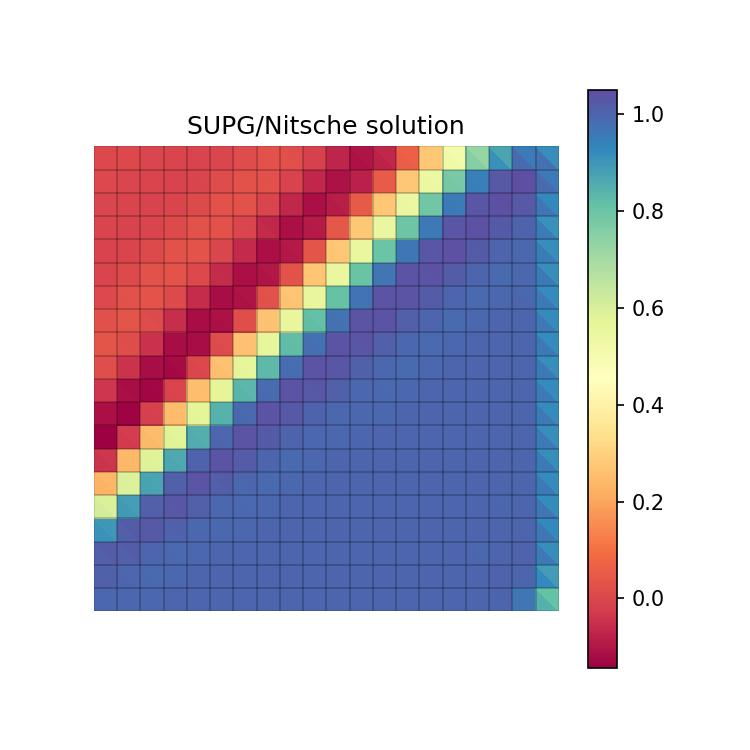

<IPython.core.display.Javascript object>


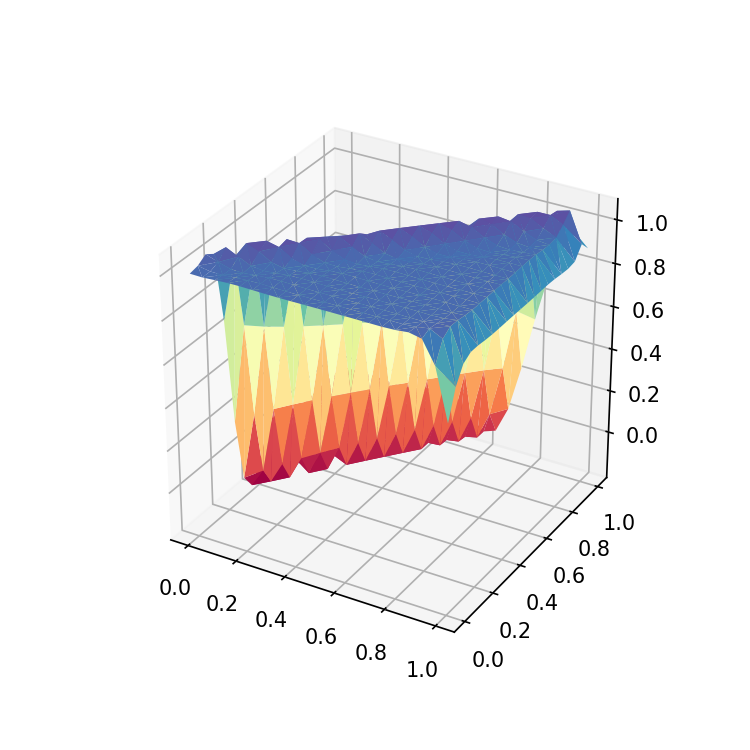

In [69]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

degree = 1 #degree of basis functions. degree = 1 gives SUPG
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)]) #advection
ns.kappa = 1e-6
ns.basis = topo.basis('spline', degree = degree)
ns.u = 'basis_i ?dofs_i'
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.s = -1 # 1 or -1 depending on whether you want symmetric or skew-symmetric 
ns.lamb = 17 # lagrange multiplier

#element intrinsic time scale
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'


badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2)
ns.badbnd = badbnd[1]

#residual
res = topo.integral( '(kappa basis_i,j u_,j  + u_,n  a_n basis_i) d:x' @ ns, degree = degree * 2) 
res -= topo.boundary.integral('kappa basis_i u_,k n_k d:x' @ns, degree = degree * 2)
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 
    #weak BCs
res += topo.boundary['top'].integral('kappa lamb basis_i u / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['right'].integral('kappa lamb basis_i u / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['bottom'].integral('kappa lamb basis_i (u - 1) / (h) d:x' @ ns, degree= degree * 2)
res += topo.boundary['left'].integral('kappa lamb basis_i (u - badbnd) / (h)  d:x' @ ns, degree= degree * 2)

res -= topo.boundary['top'].integral('s kappa basis_i,j u n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['right'].integral('s kappa  basis_i,j u n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['bottom'].integral('s kappa basis_i,j (u - 1) n_j d:x' @ ns, degree= degree * 2)
res -= topo.boundary['left'].integral('s kappa basis_i,j (u - badbnd) n_j d:x' @ ns, degree= degree * 2)


lhs = ntl.solver.solve_linear('dofs', res)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG/Nitsche solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

In [70]:
#print((beta *beta).sum(0)) #ct.getfullargspec(topo.basis))
#elp(np.dot)#(topo.basis)
#help(ntl.export.triplot)
#print(topo.boundary)
#help(bezier.eval)
#a = [1 ,2, 3, 4, 5, 8, 6, 7]
#print(a[:])
#print(np.cos(np.pi))

In [23]:
help(bezier.tri)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [77]:
sqr = topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns,degree = degree*2 )  #ischeme = 'bezier6')#
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15)#this applies the boundary condition to u
print(cons[50])
print(np.isfinite(cons[50]))
ite = np.array([])
#ite = np.append([1, 4, 5, 6], ite)
for i in range(len(cons)):
    if np.isfinite(cons[i]) == True :
        ite = np.append(ite, [i])
print(ite)
print(cons)

optimize > constrained 21/441 dofs
optimize > optimum value 0.00e+00
nan
False
[ 20.  41.  62.  83. 104. 125. 146. 167. 188. 209. 230. 251. 272. 293.
 314. 335. 356. 377. 398. 419. 440.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan  0. nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan  0.
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan
 nan nan n

In [79]:
ite = np.array([])
for j in range(5):
    ite = np.append(ite, [j])
print(ite)
print(ite[3, 2, 1])

[0. 1. 2. 3. 4.]


IndexError: too many indices for array